In [110]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# **1 Exploration and Preprocessing**

In [111]:
prices_df = pd.read_csv('../data/original/price_data.csv')
features_df = pd.read_csv('../data/processed/features.csv')
# m_potato = pd.read_csv('../data/processed/m_potato_features.csv')

In [112]:
features_df['date'] = pd.to_datetime(features_df['date'])
features_df.set_index('date', inplace=True)
features_df


,Holiday,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
date,,,,,,,,
2013-06-16,0,22.0,18.8,20.4,41.7,7.6,5.65,1.27
2013-06-17,1,24.0,19.2,21.4,9.6,6.4,16.08,3.14
2013-06-18,0,24.9,19.4,21.7,11.0,7.4,14.58,2.99
2013-06-19,0,22.0,19.2,20.3,100.1,5.4,3.96,0.97
2013-06-20,0,25.1,17.7,21.0,3.4,6.6,19.90,3.92
...,...,...,...,...,...,...,...,...
2021-05-09,0,22.2,14.5,18.1,3.2,9.2,21.30,3.89
2021-05-10,0,22.2,14.6,18.2,5.0,5.4,18.96,3.52
2021-05-11,0,22.4,14.5,17.9,3.9,6.9,16.93,3.14


In [113]:
potato_prices = prices_df[prices_df['Commodity'] == 'Potato Red'].copy()
potato_prices.drop(columns=['Commodity', 'SN', 'Unit', 'Minimum', 'Maximum'], inplace=True)
potato_prices.rename(columns={'Date':'date'}, inplace=True)

potato_prices['date'] = pd.to_datetime(potato_prices['date'])
potato_prices.set_index('date', inplace=True)

potato_prices

,Average
date,
2013-06-16,20.5
2013-06-17,20.5
2013-06-18,19.5
2013-06-19,20.5
2013-06-20,20.5
...,...
2021-05-09,36.5
2021-05-10,36.5
2021-05-11,36.5


In [114]:
potato_prices = potato_prices.resample('D').asfreq()

potato_prices.isna().sum()

Average    143
dtype: int64

In [115]:
potato_prices = potato_prices.ffill()

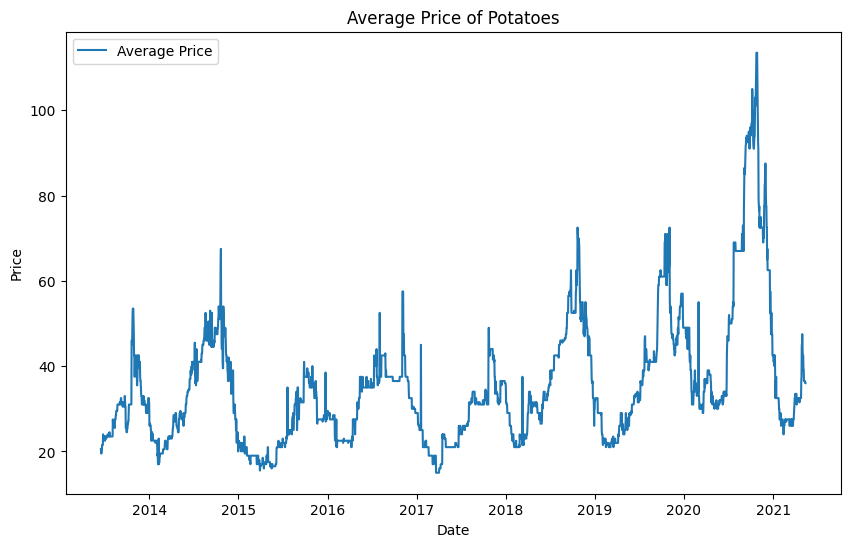

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(potato_prices['Average'], label='Average Price')
plt.title('Average Price of Potatoes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

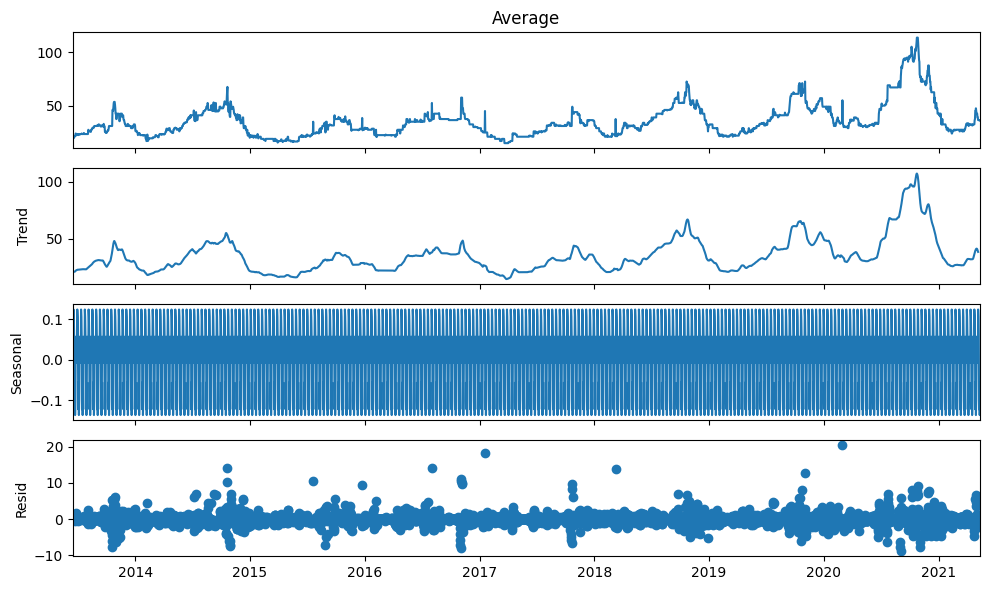

In [117]:
decomposed = seasonal_decompose(potato_prices['Average'], model='additive', period=12)

plt.rcParams['figure.figsize'] = [10, 6]  
decomposed.plot()
plt.show()

In [118]:
# Time-based features
potato_prices['Day'] = potato_prices.index.day
potato_prices['Week'] = potato_prices.index.isocalendar().week
potato_prices['Month'] = potato_prices.index.month
potato_prices['Year'] = potato_prices.index.year
potato_prices['Quarter'] = potato_prices.index.quarter


potato_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2889 entries, 2013-06-16 to 2021-05-13
Freq: D
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Average  2889 non-null   float64
 1   Day      2889 non-null   int32  
 2   Week     2889 non-null   UInt32 
 3   Month    2889 non-null   int32  
 4   Year     2889 non-null   int32  
 5   Quarter  2889 non-null   int32  
dtypes: UInt32(1), float64(1), int32(4)
memory usage: 104.4 KB


In [119]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2889 entries, 2013-06-16 to 2021-05-13
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Holiday                     2889 non-null   int64  
 1   temperature_2m_max          2889 non-null   float64
 2   temperature_2m_min          2889 non-null   float64
 3   temperature_2m_mean         2889 non-null   float64
 4   precipitation_sum           2889 non-null   float64
 5   wind_speed_10m_max          2889 non-null   float64
 6   shortwave_radiation_sum     2889 non-null   float64
 7   et0_fao_evapotranspiration  2889 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 203.1 KB


In [120]:
potato_prices = potato_prices.join(features_df, how='inner')
potato_prices

,Average,Day,Week,Month,Year,Quarter,Holiday,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
date,,,,,,,,,,,,,,
2013-06-16,20.5,16,24,6,2013,2,0,22.0,18.8,20.4,41.7,7.6,5.65,1.27
2013-06-17,20.5,17,25,6,2013,2,1,24.0,19.2,21.4,9.6,6.4,16.08,3.14
2013-06-18,19.5,18,25,6,2013,2,0,24.9,19.4,21.7,11.0,7.4,14.58,2.99
2013-06-19,20.5,19,25,6,2013,2,0,22.0,19.2,20.3,100.1,5.4,3.96,0.97
2013-06-20,20.5,20,25,6,2013,2,0,25.1,17.7,21.0,3.4,6.6,19.90,3.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-09,36.5,9,18,5,2021,2,0,22.2,14.5,18.1,3.2,9.2,21.30,3.89
2021-05-10,36.5,10,19,5,2021,2,0,22.2,14.6,18.2,5.0,5.4,18.96,3.52
2021-05-11,36.5,11,19,5,2021,2,0,22.4,14.5,17.9,3.9,6.9,16.93,3.14


In [121]:
save = potato_prices.copy()
save.reset_index(inplace=True)
save.to_csv("../data/processed/full_dataset.csv", index=False)

In [122]:
# Step 1: Separate features and target
# features all columns except 'Average'
features = potato_prices.drop(columns='Average') 
target = potato_prices[['Average']]  # Target column

# Step 2: Split the data into training and test sets
test_size = 365
x_train, x_test = features[:-test_size], features[-test_size:]
y_train, y_test = target[:-test_size], target[-test_size:]

# Step 3: Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Step 4: Fit scalers only on the training set
x_train_scaled = feature_scaler.fit_transform(x_train)
y_train_scaled = target_scaler.fit_transform(y_train)

# Step 5: Transform the test set using the scalers fitted on the training data
x_test_scaled = feature_scaler.transform(x_test)
y_test_scaled = target_scaler.transform(y_test)

# **2 Modelling**

In [123]:
models = {
    'Lasso': (Lasso( random_state=42), {
        'alpha': np.logspace(-4, 1, 100),  # Regularization strength
        'max_iter': [1000, 2000, 3000, 5000],  # Maximum number of iterations
        'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for optimization
    }),
}

## **2.1 Lasso Regression**

In [124]:
# check stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    """
    Check stationarity of a series and apply differencing until it becomes stationary.
    """
    # Ensure no infinite recursion
    max_diff = 5  # Set a limit to the number of differencing steps
    diff_count = 0
    
    while diff_count < max_diff:
        result = adfuller(series.dropna())  # Drop NaNs for ADF test
        if result[1] <= 0.05:
            print(f"The series is stationary after {diff_count} differencing step(s).")
            print('\n')
            return None
        else:
            print(f"The series is non-stationary. Applying differencing (step {diff_count + 1})...")
            series = series.diff()
            diff_count += 1
    
    raise ValueError("The series could not be made stationary within the differencing limit.")


check_stationarity(potato_prices['Average'])


The series is stationary after 0 differencing step(s).




In [125]:
# Train Lasso Regression model
lasso = Lasso(alpha=0.1, random_state=42)  # Regularization strength (tune this hyperparameter)
lasso.fit(x_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(x_test_scaled)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 17.204380402216298


In [126]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)


grid_search = GridSearchCV(estimator=models['Lasso'][0], param_grid=models['Lasso'][1], cv=tscv, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(x_train_scaled, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_lasso = Lasso(**best_params)
best_lasso.fit(x_train_scaled, y_train)

y_pred = best_lasso.predict(x_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Fitting 10 folds for each of 1200 candidates, totalling 12000 fits
Best parameters: {'alpha': np.float64(0.2420128264794381), 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error: 17.77420115219438


In [127]:
# Get feature importance (coefficients)
coefficients = best_lasso.coef_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': x_train.columns,  # Replace with your feature names
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

print(importance_df)

                       Feature  Coefficient
4                      Quarter    17.194387
3                         Year    10.199085
0                          Day     0.000000
2                        Month     0.000000
1                         Week     0.000000
5                      Holiday     0.000000
6           temperature_2m_max    -0.000000
7           temperature_2m_min     0.000000
8          temperature_2m_mean     0.000000
9            precipitation_sum     0.000000
10          wind_speed_10m_max    -0.000000
11     shortwave_radiation_sum    -0.000000
12  et0_fao_evapotranspiration    -0.000000


In [128]:
joblib.dump(best_lasso, '../saved_models/lasso.pkl')

['../saved_models/lasso.pkl']

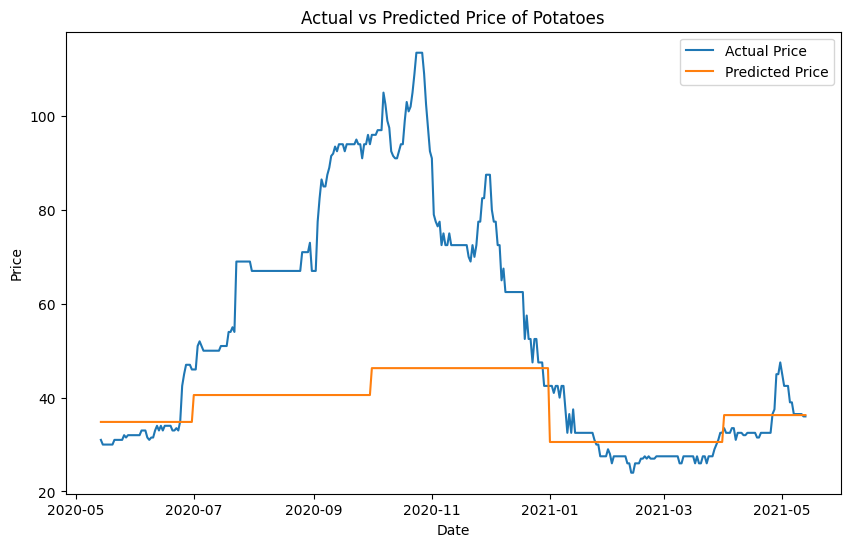

In [129]:
#plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Price of Potatoes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

---

## **2.2 XGBoost**

In [158]:
""" 
Wrapper for XGBRegressor to ensure compatibility with scikit-learn tools like GridSearchCV.
The wrapper addresses the lack of full scikit-learn API compliance in XGBRegressor 
(e.g., missing `__sklearn_tags__`), preventing warnings and ensuring seamless integration
with pipelines and hyperparameter tuning workflows.
"""

from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBRegressor

class SklearnXGBWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
    
    def fit(self, X, y, **fit_params):
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self
    
    def get_booster(self):
        return self.model.get_booster()

In [159]:
models = {
    'XGBRegressor': (SklearnXGBWrapper(), {
        'learning_rate': np.logspace(-5, -1, 50),
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'n_estimators': [100, 200, 300, 400, 500]
    })
}

In [160]:
model = model = SklearnXGBWrapper()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

mse = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mse}')

Mean Absolute Error: 17.17129898071289


In [161]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(estimator=models['XGBRegressor'][0], param_distributions=models['XGBRegressor'][1], n_iter=100, cv=tscv, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
randomized_search.fit(x_train_scaled, y_train)

# grid_search = GridSearchCV(estimator=models['XGBRegressor'][0], param_grid=models['XGBRegressor'][1], cv=tscv, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
# grid_search.fit(x_train_scaled, y_train)

best_params = randomized_search.best_params_
print(f"Best parameters: {best_params}")


best_xgboost = SklearnXGBWrapper(**best_params)
best_xgboost.fit(x_train_scaled, y_train)

y_pred = best_xgboost.predict(x_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': np.float64(0.004941713361323833), 'gamma': 0, 'colsample_bytree': 0.6}
Mean Absolute Error: 18.34564208984375


In [162]:
# Get feature importance
booster = best_xgboost.get_booster()
importance = best_xgboost.get_booster().get_score(importance_type='weight')

print(booster.feature_names)

None


In [163]:
# Convert to a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Map feature names to column names from x_train.columns
column_names = list(x_train.columns)  # Extract column names from x_train
importance_df['Feature'] = importance_df['Feature'].apply(lambda f: column_names[int(f[1:])])

print(importance_df)

                       Feature  Importance
1                         Week      2499.0
3                         Year      2447.0
8          temperature_2m_mean      1284.0
7           temperature_2m_min      1260.0
6           temperature_2m_max      1243.0
11     shortwave_radiation_sum      1152.0
2                        Month      1018.0
10          wind_speed_10m_max       936.0
0                          Day       889.0
12  et0_fao_evapotranspiration       833.0
9            precipitation_sum       775.0
4                      Quarter       109.0
5                      Holiday        33.0


In [164]:
# Extract features present in the importance DataFrame
present_features = importance_df['Feature'].tolist()

# Identify missing features
missing_features = [col for col in column_names if col not in present_features]

# Print missing features
print("Removed Features:", missing_features)

Removed Features: []


In [165]:
joblib.dump(best_xgboost, '../saved_models/xgboost.pkl')

['../saved_models/xgboost.pkl']

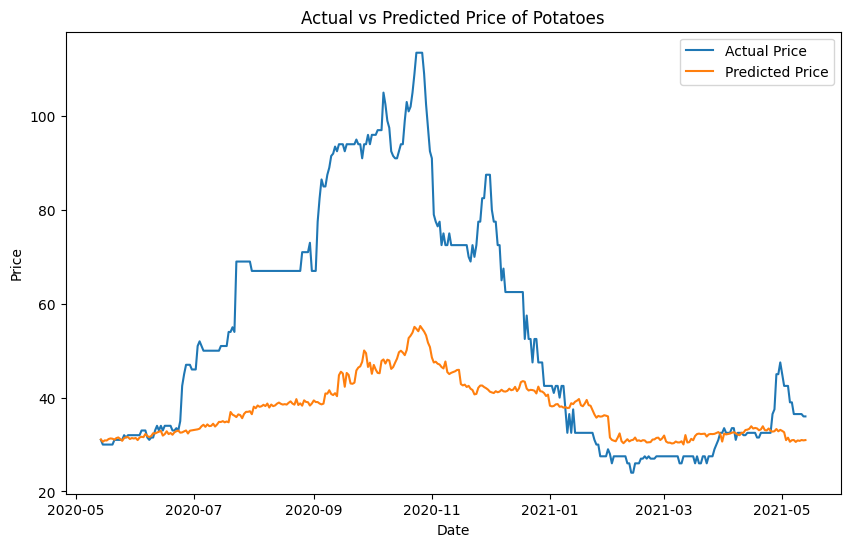

In [166]:
#plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Price of Potatoes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

---

## **2.3 LSTM**

In [167]:
def create_sequences(x, y, time_steps):
    sequences_x, sequences_y = [], []
    for i in range(len(x) - time_steps):
        sequences_x.append(x[i:i + time_steps])  # Use time_steps rows of features
        sequences_y.append(y[i + time_steps])   # Predict the target at the next step
    return np.array(sequences_x), np.array(sequences_y)

In [168]:
# Define the number of time steps
time_steps = 7

features = potato_prices.drop(columns='Average') 
target = potato_prices[['Average']]  # Target column

# Step 2: Split the data into training and test sets
test_size = 365 + time_steps
x_train, x_test = features[:-test_size], features[-test_size:]
y_train, y_test = target[:-test_size], target[-test_size:]

# Step 3: Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Step 4: Fit scalers only on the training set
x_train_scaled = feature_scaler.fit_transform(x_train)
y_train_scaled = target_scaler.fit_transform(y_train)

# Step 5: Transform the test set using the scalers fitted on the training data
x_test_scaled = feature_scaler.transform(x_test)
y_test_scaled = target_scaler.transform(y_test)

# Create sequences
x_train_seq, y_train_seq = create_sequences(x_train_scaled, y_train_scaled, time_steps)
x_test_seq, y_test_seq = create_sequences(x_test_scaled, y_test_scaled, time_steps)

In [169]:
print(f"Length of x_train_scaled: {len(x_train_scaled)}")
print(f"Length of y_train_scaled: {len(y_train_scaled)}")
print(f"Time steps: {time_steps}")

Length of x_train_scaled: 2517
Length of y_train_scaled: 2517
Time steps: 7


In [170]:
print(f"Length of x_test_scaled: {len(x_test_scaled)}")
print(f"Length of y_test_scaled: {len(y_test_scaled)}")
print(f"Time steps: {time_steps}")

Length of x_test_scaled: 372
Length of y_test_scaled: 372
Time steps: 7


In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(x_train_seq.shape[1], x_train_seq.shape[2])),
    Bidirectional(LSTM(64, activation='relu', input_shape=(x_train_seq.shape[1], x_train_seq.shape[2]), return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, activation='relu')),
    Dropout(0.2),
    Dense(1)
])

init_weights = model.get_weights()


model.summary()

c:\Users\lukas\Documents\Uni\PAII\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 128)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,881 (542.50 KB)

 Trainable params: 138,881 (542.50 KB)

 Non-trainable params: 0 (0.00 B)

In [172]:
lr_schd = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(optimizer=Adam(), loss='mean_squared_error')

hist = model.fit(x_train_seq, y_train_seq, epochs=100, callbacks=[lr_schd])

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1396 - learning_rate: 1.0000e-08
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1384 - learning_rate: 1.1220e-08
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1363 - learning_rate: 1.2589e-08
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1417 - learning_rate: 1.4125e-08
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1340 - learning_rate: 1.5849e-08
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1360 - learning_rate: 1.7783e-08
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1352 - learning_rate: 1.9953e-08
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1402 - learning_rate: 2.2387e-08
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1381 - learning_rate: 2.5119e-08
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1397 - learning_rate: 2.8184e-08
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/s

(np.float64(1e-08), np.float64(0.001), np.float64(0.0), np.float64(1.0))

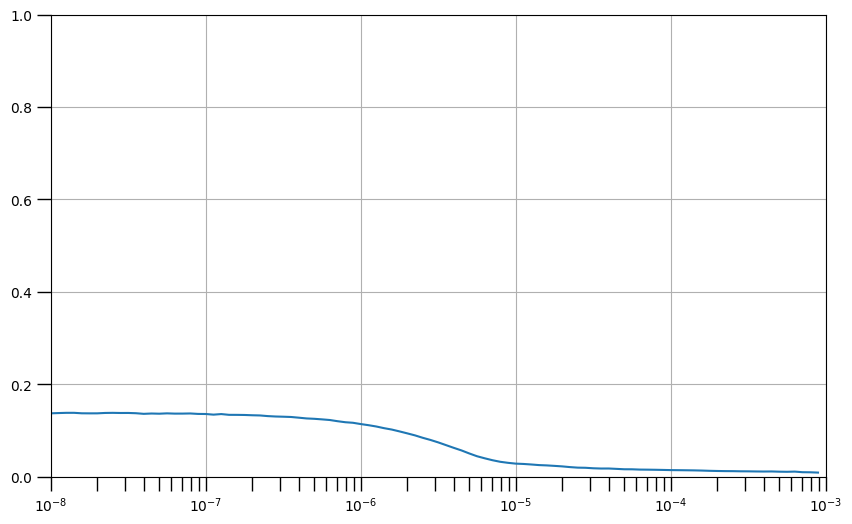

In [173]:
lr_arr = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lr_arr, hist.history['loss'])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 1])

In [174]:
# Extract the loss values from history
losses = np.array(hist.history['loss'])
# Calculate the rate of change (derivative) of the loss
loss_grad = np.gradient(losses)

# Find the learning rate where the loss gradient is minimal
optimal_lr_idx = np.argmin(np.abs(loss_grad))
optimal_lr = lr_arr[optimal_lr_idx]

print(f"Optimal learning rate: {optimal_lr}")

Optimal learning rate: 0.0003981071705534969


In [175]:
model.set_weights(init_weights)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=optimal_lr), metrics=['mae'])

hist = model.fit(x_train_seq, y_train_seq, epochs=300)

Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0527 - mae: 0.1730
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0169 - mae: 0.1028
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0165 - mae: 0.1015
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0147 - mae: 0.0940
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0137 - mae: 0.0914
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0127 - mae: 0.0891
Epoch 7/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0115 - mae: 0.0849
Epoch 8/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0118 - mae: 0.0863
Epoch 9/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0118 - mae: 0.0851
Epoch 10/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0110 - mae: 0.0826
Epoch 11/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0113 - mae: 0.0830
Epoch 12/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0114 - mae: 0.0826
Epoch 13/300
79/79 ━━━━━━

In [177]:
model.save('../saved_models/lstm.keras')

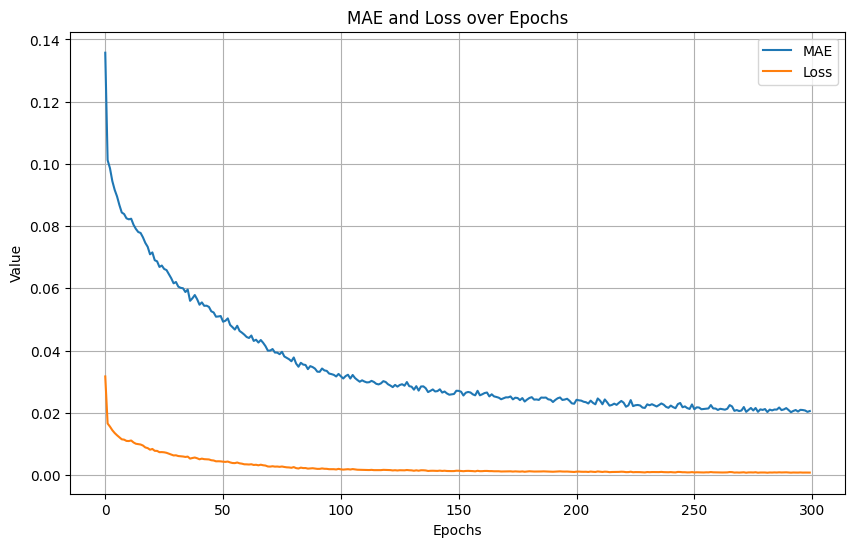

In [178]:
hist_mae = hist.history['mae']
hist_loss = hist.history['loss']

# Extract history values
hist_mae = hist.history['mae']
hist_loss = hist.history['loss']

# Plot MAE and Loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(hist_mae)), hist_mae, label="MAE")
plt.plot(range(len(hist_loss)), hist_loss, label="Loss")
plt.title("MAE and Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [179]:
print(x_train_seq.shape)  # Should be (samples, timesteps, features)
print(x_test_seq.shape)   # Should be (samples, timesteps, features)

(2510, 7, 13)
(365, 7, 13)


In [180]:
# Step 10: Predict on the test set
y_pred_scaled = model.predict(x_test_seq)

# Step 11: Inverse transform the predictions
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test = target_scaler.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step
Mean Absolute Error: 16.545232631735605


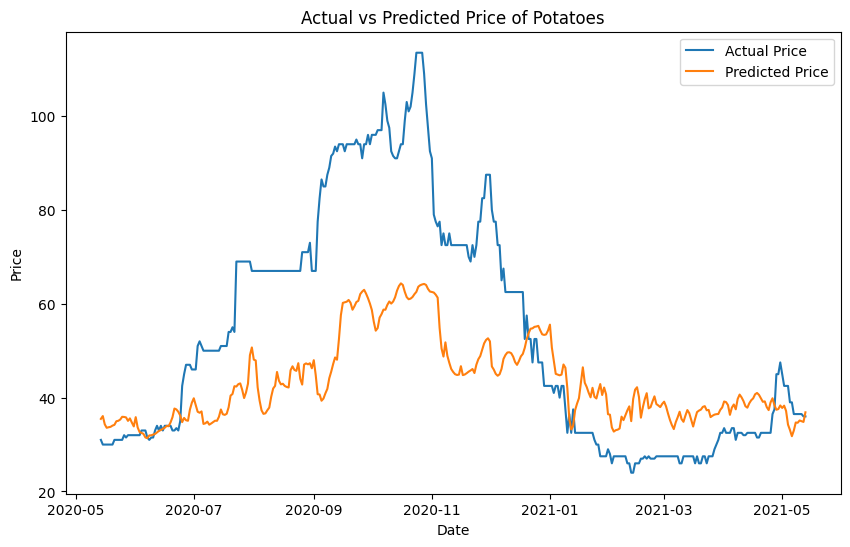

In [181]:
# Step 13: Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(potato_prices.index[-len(y_test):], y_test, label="Actual Price")
plt.plot(potato_prices.index[-len(y_test):], y_pred, label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual vs Predicted Price of Potatoes")
plt.legend()
plt.show()